# Import Packages

In [1]:
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import utils
import pandas as pd
import numpy as np
import math
import random
from isoweek import Week
import lightgbm as lgb
import pickle
from sklearn.metrics import mean_squared_error
from IPython.display import clear_output

# Settings

In [2]:
forecast_horizon = 1
path_models = utils.get_project_root() + '/03_Forecasting_LightGBM/models/'
target_variable = 'Turnover' # Either 'Turnover' or 'Sales_QTY'

# Import Data

In [3]:
query = 'SELECT * FROM `globus-datahub-dev.Verteiler_PoC.timeseries_sales_weekly` where Year >= 2015 and (Year <= 2019 OR (Year = 2020 AND Week <= 47))  order by sku, site_id, year, week'
df_raw = utils.bq_to_dataframe(
    query, verbose=True).pipe(utils.reduce_memory_usage)

********************
Query Duration:  0:08:28.634521
Mem. usage decreased to 1469.44 Mb (15.1% reduction)


In [4]:
df = df_raw.copy()
df

,Week,Year,Date,Site_ID,SKU,Sales_QTY,Turnover,Price,Season_Year,Vendor_ID,...,Warengruppe_ID,Warengruppe_Desc,Subclass_Desc,Class_Desc,Web_Article,Web_Article_From,Web_Article_To,CENSHARE_CAT_1,CENSHARE_CAT_2,CENSHARE_CAT_3
0,1,2015,2015W1,101,1014557,5.0,129.500000,25.90,9999,0000126656,...,721,Küche,Zerkleinern,Kuechenhelfer,X,2015-01-28,9999-12-31,Kuche,Kuchenmesser,wiegemesser
1,2,2015,2015W2,101,1014557,2.0,51.799999,25.90,9999,0000126656,...,721,Küche,Zerkleinern,Kuechenhelfer,X,2015-01-28,9999-12-31,Kuche,Kuchenmesser,wiegemesser
2,3,2015,2015W3,101,1014557,0.0,0.000000,25.90,9999,0000126656,...,721,Küche,Zerkleinern,Kuechenhelfer,X,2015-01-28,9999-12-31,Kuche,Kuchenmesser,wiegemesser
3,4,2015,2015W4,101,1014557,1.0,25.900000,25.90,9999,0000126656,...,721,Küche,Zerkleinern,Kuechenhelfer,X,2015-01-28,9999-12-31,Kuche,Kuchenmesser,wiegemesser
4,5,2015,2015W5,101,1014557,0.0,0.000000,25.90,9999,0000126656,...,721,Küche,Zerkleinern,Kuechenhelfer,X,2015-01-28,9999-12-31,Kuche,Kuchenmesser,wiegemesser
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7821434,47,2020,2020W47,101,1289328500,4.0,56.090000,14.90,9999,0000948934,...,988,Wohnboutique,Wohnaccessoires,HAY,X,2021-02-25,9999-12-31,Ordnung & Aufbewahrung,Korbe & Boxen,korbe
7821435,47,2020,2020W47,101,1289328600,2.0,29.799999,14.90,9999,0000948934,...,988,Wohnboutique,Wohnaccessoires,HAY,X,2021-02-25,9999-12-31,Ordnung & Aufbewahrung,Korbe & Boxen,korbe
7821436,47,2020,2020W47,101,1289328700,5.0,32.869999,6.57,9999,0000948934,...,988,Wohnboutique,Wohnaccessoires,HAY,X,2021-02-25,9999-12-31,Ordnung & Aufbewahrung,Korbe & Boxen,korbe
7821437,47,2020,2020W47,101,1289328800,4.0,27.600000,6.90,9999,0000948934,...,988,Wohnboutique,Wohnaccessoires,HAY,X,2021-02-25,9999-12-31,Ordnung & Aufbewahrung,Korbe & Boxen,korbe


# Preprocess Data

In [5]:
# Get rid of negative Sales / Turnover
df.loc[:, 'Sales_QTY'] = df.Sales_QTY.clip(lower=0)
df.loc[:, 'Turnover'] = df.Turnover.clip(lower=0)

# Classify Data

Current Classification (A: Top-Seller, B: Medium-Seller, C: Low-Seller)

A:
At least one in 6 different weeks & mean sales per week greater 0.3

B:
At least one in 6 different weeks & mean sales per week greater 0.1

C:
All the rest


In [6]:
df['Classification'] = 'C'

for i, g in df.groupby(['Site_ID', 'SKU']):
    
    if  (g.Sales_QTY[g.Sales_QTY > 0].count() > 5) & (g.Sales_QTY[g.Sales_QTY > 0].count() / g.Sales_QTY.count() > 0.4):
        df.iloc[list(g.index), df.columns.get_loc('Classification')] = 'A'
        
    elif (g.Sales_QTY[g.Sales_QTY > 0].count() > 5) & (g.Sales_QTY[g.Sales_QTY > 0].count() / g.Sales_QTY.count() > 0.1):
        df.iloc[list(g.index), df.columns.get_loc('Classification')] = 'B'

        
# Print summary: number of Time-Series per Classification
df[['Site_ID', 'SKU', 'Classification']].drop_duplicates()[['Classification']].value_counts()

Classification
C                 32503
B                 21374
A                  5392
dtype: int64

# Plot Time Series

In [8]:
n_series = 8

In [9]:
def plot_timeseries(samples: int, sales: pd.core.frame.DataFrame) -> None:
    """
    Vizualize certain timeseries.
    :param: samples: list of lists with Site ID - Article combinations to be vizualized.
            Example: [['g590', 1282277826], ['g115', 1254150002], ['g102', 1264627019]]
    :param: sales: DataFrame containing the sales data (columns SKU, Site_ID & Year_Week required)
    :return None
    """
    fig, axs = plt.subplots(math.ceil(n_series / 2), 2, figsize=(15, n_series * 1.5))
    axs = axs.flatten()
    ax_idx = 0

    for site, article in samples:
        df_article = sales.loc[df.SKU == article].loc[df.Site_ID == site].sort_values(by='Date').reset_index()

        df_article.plot(x='Date',
                     y='Sales_QTY',
                     title= f'SKU: {article}, Site ID: {site}',
                     ax=axs[ax_idx])
        ax_idx += 1

    plt.tight_layout()
    plt.show()

## Class A (Top Seller)

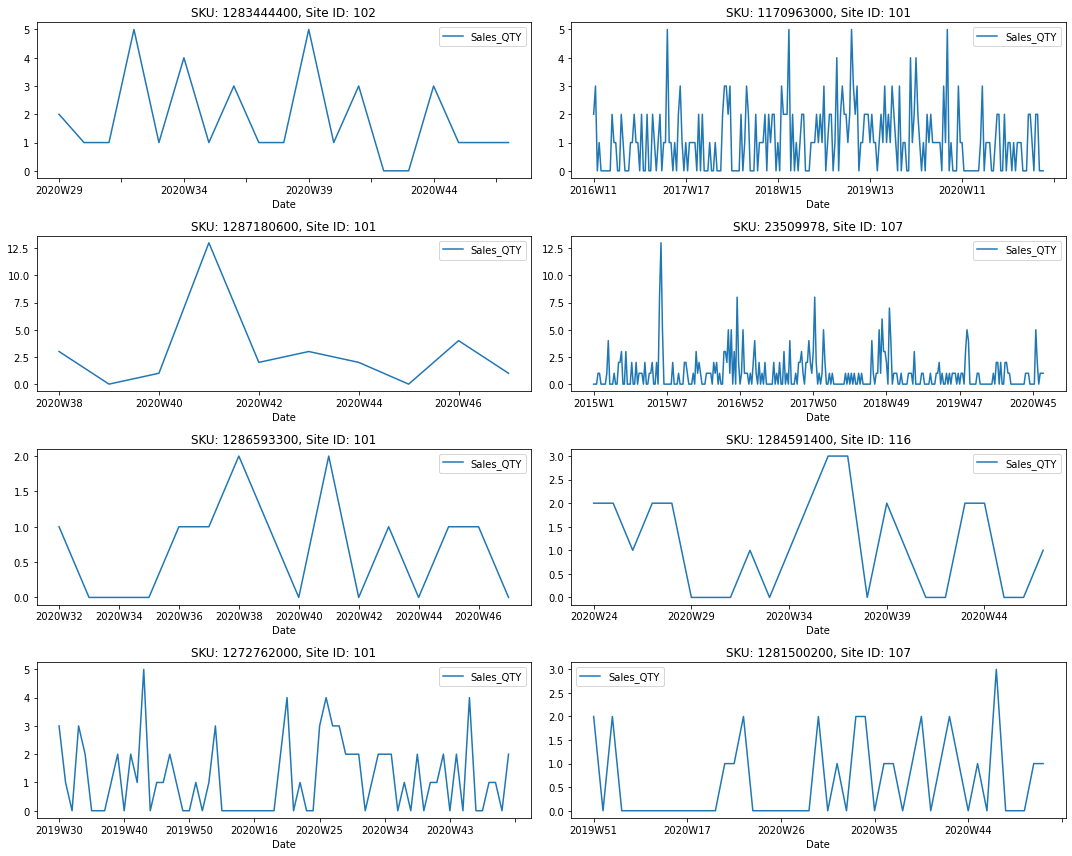

In [10]:
classification = 'A'
samples = df.loc[df.Classification == classification][['Site_ID','SKU']].drop_duplicates().sample(n=n_series, random_state=4).values.tolist()
plot_timeseries(samples, df)

## Class B (Medium Seller)

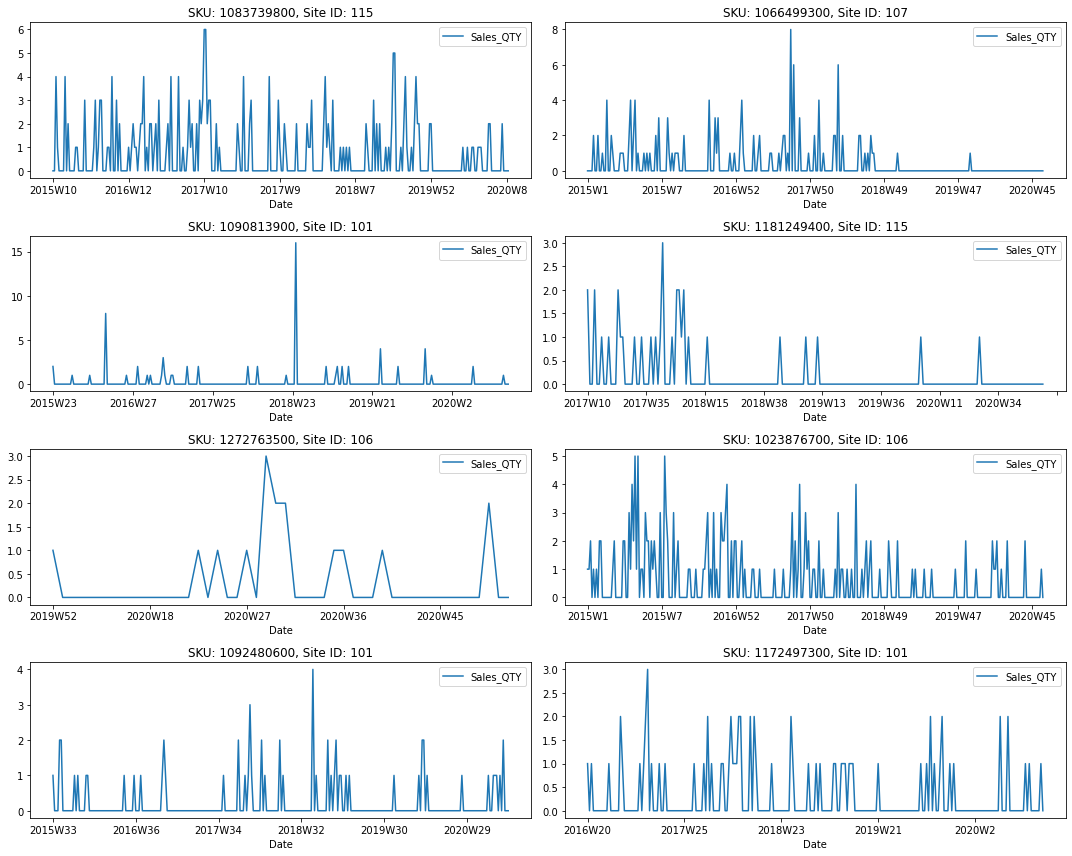

In [11]:
classification = 'B'
samples = df.loc[df.Classification == classification][['Site_ID','SKU']].drop_duplicates().sample(n=n_series, random_state=4).values.tolist()
plot_timeseries(samples, df)

## Class C (Low Seller)

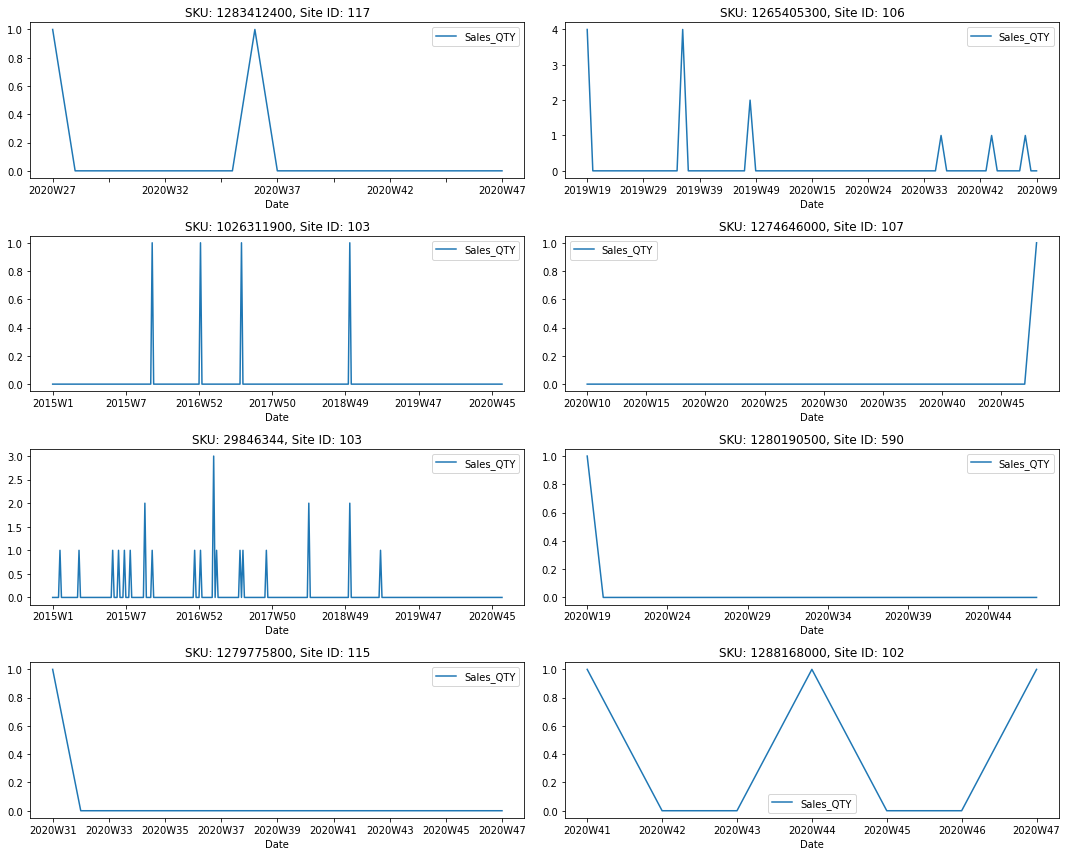

In [12]:
classification = 'C'
samples = df.loc[df.Classification == classification][['Site_ID','SKU']].drop_duplicates().sample(n=n_series, random_state=4).values.tolist()
plot_timeseries(samples, df)

# Feature Engineering

In [4]:
df['rolling_mean_w4'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(1).rolling(window=4,min_periods=0).mean()).fillna(0)

df['rolling_mean_w8'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(1).rolling(window=8,min_periods=0).mean()).fillna(0)

df['lag_w1'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(1))

df['lag_w2'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(2))

df['lag_w3'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(3))

df['lag_w4'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(4))

df['lag_y1'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(52))

df['lag_y2'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(104))


In [5]:
cat_features = [
'Week', 'Year', 'Site_ID', 'SKU','Season_Year',
       'Vendor_ID', 'Price_Level', 'Web_Article', 'CENSHARE_CAT_1',
       'CENSHARE_CAT_2', 'CENSHARE_CAT_3'
]

num_features = [
'rolling_mean_w4', 'lag_w1',
       'lag_w2', 'lag_w3', 'lag_w4', 'lag_y1', 'lag_y2'
]

features = cat_features + num_features

In [6]:
# Convert categorical features to integers 
df, encoders_dict = utils.encode_categorical(df, cat_features, return_encoders = True)

# Forecasting

In [7]:
splits = utils.get_splits(df, fh=forecast_horizon, n_splits=1)

In [8]:
# Store results in dataframe and validate the error at the end.
result_df = pd.DataFrame(columns=['Week', 'Year', 'Site_ID', 'SKU','Prediction']+[target_variable] )

## Class A (Top Seller)

In [9]:
model_params = {
    'seed': 10,
    'objective': 'poisson',
    'metric': 'rmse',
    'num_leaves': 2^4,
    'max_bin': 1000,
    }

In [10]:
rmse = []

df_class = df.loc[df.Classification == 'A'].copy()

save_models = True

for week, year in splits:
    print(f'\n\n****** {year}W{week} ******')
    
    result_classification = pd.DataFrame(columns=['Week', 'Year', 'Site_ID', 'SKU','Prediction']+[target_variable])
        
    evals_result = {}
    
    week=int(week)
    year=int(year)
    
    # Train data: same year and past week OR past year
    x_train = df_class.loc[((df_class.Year == (Week(year, week))[0]) & (df_class.Week <= (Week(year, week))[1])) | (df_class.Year < (Week(year, week))[0])][features]
    y_train = df_class.loc[((df_class.Year == (Week(year, week))[0]) & (df_class.Week <= (Week(year, week))[1])) | (df_class.Year < (Week(year, week))[0])][target_variable]

    x_test = df_class.loc[df_class.Year == (Week(year, week)+1)[0]].loc[df_class.Week == (Week(year, week)+1)[1]][features]
    y_test = df_class.loc[df_class.Year == (Week(year, week)+1)[0]].loc[df_class.Week == (Week(year, week)+1)[1]][target_variable]
    
    
    
    train_data = lgb.Dataset(x_train, label=y_train,
                             categorical_feature=cat_features, free_raw_data=False,
                           )
    validation_data = lgb.Dataset(
        x_test, label=y_test, categorical_feature=cat_features, free_raw_data=False, reference=train_data,
    )
    
    
    
    gbm = lgb.train(model_params, train_data, valid_sets=[train_data, validation_data],
                    evals_result=evals_result, num_boost_round=1000,
                    verbose_eval=25, early_stopping_rounds=20,
                   )

    
    y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration)
    
    
    if save_models:
        print('log: save model and evals result')
        gbm.save_model(path_models + f'gbm_{year}w{week}.txt', num_iteration=gbm.best_iteration) 

        evals_result_p = open(path_models+ f'evals_result_{year}w{week}.pkl', 'wb')
        pickle.dump(evals_result, evals_result_p)
        evals_result_p.close()
        
        
    # Gather results of this article category and store them in DataFrame
    result_cat = x_test[['Week', 'Year', 'Site_ID', 'SKU']].copy()
    result_cat[target_variable] = list(y_test)
    result_cat['Prediction'] = list(y_pred)
        
        
    # Append results of this category to classification DataFrame as well as overall DataFrame
    result_classification = result_classification.append(result_cat)
    result_df = result_df.append(result_cat)

    
    
    # Compute RMSE for entire article classificaiton
    rmse.append(mean_squared_error(result_classification.Prediction, result_classification[target_variable], squared=False))

# clear output
clear_output()
    
# Print results
print('RMSE:\n', rmse)
print('\nMean RMSE: ', np.mean(rmse))

RMSE:
 [72.89884084470754]

Mean RMSE:  72.89884084470754


## Class B (Medium Seller)

In [11]:
model_params = {
    'seed': 10,
    'objective': 'poisson',
    'metric': 'rmse',
    'num_leaves': 2^4,
    'max_bin': 1000,
    }

In [12]:
rmse = []

df_class = df.loc[df.Classification == 'B'].copy()

save_models = True

for week, year in splits:
    print(f'\n\n****** {year}W{week} ******')
    
    result_classification = pd.DataFrame(columns=['Week', 'Year', 'Site_ID', 'SKU','Prediction']+[target_variable])
        
    evals_result = {}
    
    week=int(week)
    year=int(year)
    
    # Train data: same year and past week OR past year
    x_train = df_class.loc[((df_class.Year == (Week(year, week))[0]) & (df_class.Week <= (Week(year, week))[1])) | (df_class.Year < (Week(year, week))[0])][features]
    y_train = df_class.loc[((df_class.Year == (Week(year, week))[0]) & (df_class.Week <= (Week(year, week))[1])) | (df_class.Year < (Week(year, week))[0])][target_variable]

    x_test = df_class.loc[df_class.Year == (Week(year, week)+1)[0]].loc[df_class.Week == (Week(year, week)+1)[1]][features]
    y_test = df_class.loc[df_class.Year == (Week(year, week)+1)[0]].loc[df_class.Week == (Week(year, week)+1)[1]][target_variable]
    
    
    
    train_data = lgb.Dataset(x_train, label=y_train,
                             categorical_feature=cat_features, free_raw_data=False,
                           )
    validation_data = lgb.Dataset(
        x_test, label=y_test, categorical_feature=cat_features, free_raw_data=False, reference=train_data,
    )
    
    
    
    gbm = lgb.train(model_params, train_data, valid_sets=[train_data, validation_data],
                    evals_result=evals_result, num_boost_round=1000,
                    verbose_eval=25, early_stopping_rounds=20,
                   )

    
    y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration)
    
    
    if save_models:
        print('log: save model and evals result')
        gbm.save_model(path_models + f'gbm_{year}w{week}.txt', num_iteration=gbm.best_iteration) 

        evals_result_p = open(path_models+ f'evals_result_{year}w{week}.pkl', 'wb')
        pickle.dump(evals_result, evals_result_p)
        evals_result_p.close()
        
        
    # Gather results of this article category and store them in DataFrame
    result_cat = x_test[['Week', 'Year', 'Site_ID', 'SKU']].copy()
    result_cat[target_variable] = list(y_test)
    result_cat['Prediction'] = list(y_pred)
        
        
    # Append results of this category to classification DataFrame as well as overall DataFrame
    result_classification = result_classification.append(result_cat)
    result_df = result_df.append(result_cat)

    
    
    # Compute RMSE for entire article classificaiton
    rmse.append(mean_squared_error(result_classification.Prediction, result_classification[target_variable], squared=False))

# clear output
clear_output()
    
# Print results
print('RMSE:\n', rmse)
print('\nMean RMSE: ', np.mean(rmse))

RMSE:
 [71.0215841546984]

Mean RMSE:  71.0215841546984


## Class C (Low Seller)

In [13]:
rmse = []

df_class = df.loc[df.Classification == 'C'].copy()

save_models = True

for week, year in splits:
    print(f'\n\n****** {year}W{week} ******')
    
    result_classification = pd.DataFrame(columns=['Week', 'Year', 'Site_ID', 'SKU','Prediction']+[target_variable])
        
    evals_result = {}
    
    week=int(week)
    year=int(year)
    
    # Train data: same year and past week OR past year
    x_train = df_class.loc[((df_class.Year == (Week(year, week))[0]) & (df_class.Week <= (Week(year, week))[1])) | (df_class.Year < (Week(year, week))[0])][features]
    y_train = df_class.loc[((df_class.Year == (Week(year, week))[0]) & (df_class.Week <= (Week(year, week))[1])) | (df_class.Year < (Week(year, week))[0])][target_variable]

    x_test = df_class.loc[df_class.Year == (Week(year, week)+1)[0]].loc[df_class.Week == (Week(year, week)+1)[1]][features]
    y_test = df_class.loc[df_class.Year == (Week(year, week)+1)[0]].loc[df_class.Week == (Week(year, week)+1)[1]][target_variable]
    
    
    
    train_data = lgb.Dataset(x_train, label=y_train,
                             categorical_feature=cat_features, free_raw_data=False,
                           )
    validation_data = lgb.Dataset(
        x_test, label=y_test, categorical_feature=cat_features, free_raw_data=False, reference=train_data,
    )
    
    
    
    gbm = lgb.train(model_params, train_data, valid_sets=[train_data, validation_data],
                    evals_result=evals_result, num_boost_round=1000,
                    verbose_eval=25, early_stopping_rounds=20,
                   )

    
    y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration)
    
    
    if save_models:
        print('log: save model and evals result')
        gbm.save_model(path_models + f'gbm_{year}w{week}.txt', num_iteration=gbm.best_iteration) 

        evals_result_p = open(path_models+ f'evals_result_{year}w{week}.pkl', 'wb')
        pickle.dump(evals_result, evals_result_p)
        evals_result_p.close()
        
        
    # Gather results of this article category and store them in DataFrame
    result_cat = x_test[['Week', 'Year', 'Site_ID', 'SKU']].copy()
    result_cat[target_variable] = list(y_test)
    result_cat['Prediction'] = list(y_pred)
        
        
    # Append results of this category to classification DataFrame as well as overall DataFrame
    result_classification = result_classification.append(result_cat)
    result_df = result_df.append(result_cat)

    
    
    # Compute RMSE for entire article classificaiton
    rmse.append(mean_squared_error(result_classification.Prediction, result_classification[target_variable], squared=False))

# clear output
clear_output()
    
# Print results
print('RMSE:\n', rmse)
print('\nMean RMSE: ', np.mean(rmse))

RMSE:
 [135.28044688845992]

Mean RMSE:  135.28044688845992


## Validate Overall Performance

In [14]:
mean_squared_error(result_df.Prediction, result_df.Turnover, squared=False)

111.07929945967511